In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import sys
sys.path.append("../")
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from functools import partial
import optax
from lru.analysis import *
from lru.dataloaders.regression import *
from lru.train_helpers import loss_fn
from lru.model import LRU, RNN
import pandas as pd
from utils import *
from mpl_toolkits.axes_grid1 import make_axes_locatable

import set_rcParams
from hessian_plot_utils import *

batch_size = 64
seq_len = 300
input_dim = 1
hidden_dim = 4
output_dim = 1
seed = 0

In [3]:
def S(lamb1, lamb2, rho):
    f = lambda l1, l2: 1 / (1 - l1 * l2) * (1 - rho**2 * l1 * l2) / (1 - rho * l1) / (1 - rho * l2)
    df_dl1 = jax.grad(f, 0, holomorphic=True)
    df_dl1dl2 = jax.grad(df_dl1, 1, holomorphic=True)
    return df_dl1dl2(lamb1, lamb2)

@jax.jit
def block_H(lambi, lambj, bi, bj, ci, cj, rho):
    A = bi * bj * ci * cj * S(lambi, lambj, rho)
    B = bi * bj.conjugate() * ci * cj.conjugate() * S(lambi, lambj.conjugate(), rho)
    
    return 0.5 * jnp.array([[(A + B).real[0], (-A + B).imag[0]], [(-A - B).imag[0], (-A + B).real[0]]]).T

def theory_Hessian(lambs, bs, cs, rho):
    get_line = lambda lambi, bi, ci: jnp.concatenate(jax.vmap(lambda l, b, c: block_H(lambi, l, bi, b, ci, c, rho))(lambs, bs, cs)).T
    matrix = jnp.concatenate(jax.vmap(get_line)(lambs, bs, cs))
    return matrix

def sample(seed, n, nu_0, theta_0):
    key = jax.random.PRNGKey(seed)
    key_b, key_c, key_nu, key_theta = jax.random.split(key, 4)
    bs = jax.random.normal(key_b, (n, 1), dtype = jnp.complex128)
    cs = jax.random.normal(key_c, (1, n), dtype = jnp.complex128)
    u_nu = jax.random.uniform(key_nu, (n, ), dtype = jnp.float64)
    r_max, r_min = (nu_0 + 1) / 2, nu_0
    nu = jnp.sqrt(u_nu * (r_max**2 - r_min**2) + r_min**2)
    theta = 2 * theta_0 * jax.random.uniform(key_theta, (n, ), dtype = jnp.float64) - theta_0
    lamb = nu * jnp.exp(1.j * theta)
    return lamb, bs, cs

## Visualization of H

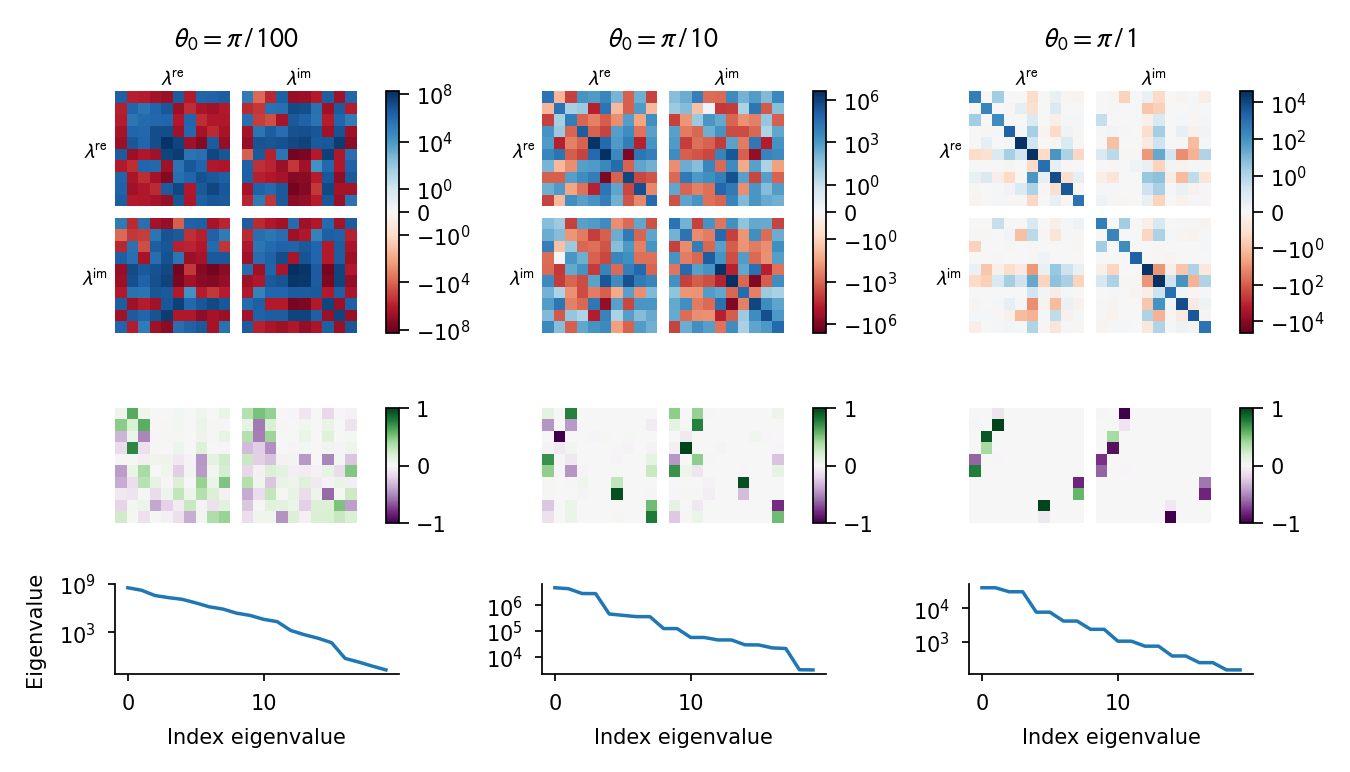

In [25]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5.5, 3.2), gridspec_kw={"height_ratios": [3, 1.5, 1]})
for i, max_phase in enumerate([0.01 * jnp.pi, 0.1 * jnp.pi, jnp.pi]):
    lambs, bs, cs = sample(53, 10, 0.99, max_phase)
    H = theory_Hessian(lambs, bs, cs.T, 0.99)
    # separate into re and im
    new_H = jnp.zeros_like(H)
    new_H = new_H.at[:len(new_H)//2, :len(new_H)//2].set(H[::2, ::2])
    new_H = new_H.at[:len(new_H)//2, len(new_H)//2:].set(H[::2, 1::2])
    new_H = new_H.at[len(new_H)//2:, :len(new_H)//2].set(H[1::2, ::2])
    new_H = new_H.at[len(new_H)//2:, len(new_H)//2:].set(H[1::2, 1::2])

    extended_H, positions, eigvals, extended_eigvects = extend_hessian(new_H, [H.shape[0]//2, H.shape[0]//2], [1])
    plot(ax, positions, [r"$\lambda^\mathrm{re}$", r"$\lambda^\mathrm{im}$"], extended_H, extended_eigvects, eigvals, i)
    ax[0, i].set_title(f"$\\theta_0 = \pi \,/\, {[100, 10, 1][i]}$", size=8)

plt.tight_layout()

## Learning

In [ ]:
# Construct the dataframe
SWEEP_IDS = [
    "RESULT_OF_scans/shrink_eigvals_p1", # LRU
    "RESULT_OF_scans/shrink_eigvals_p2", # Complex diag
    "RESULT_OF_scans/shrink_eigvals_p3", # RNN
]
OG_df = pd.concat([load_sweep(id, last_step_only=True) for id in SWEEP_IDS])
OG_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Average across seeds (take mean + std)
df_comp = OG_df.groupby(["model", "lru_param", "max_phase", "lr_base"])[["Training loss"]].mean().reset_index()
df_comp["Training loss std"] = OG_df.groupby(["model", "lru_param", "max_phase", "lr_base"])[["Training loss"]].sem().reset_index()["Training loss"]

# Pick the best learning rate
df_comp = df_comp[df_comp.groupby(["model", "lru_param", "max_phase"])["Training loss"].transform(min) == df_comp["Training loss"]]

In [6]:
data_ablation = [
    df_comp[(df_comp["model"] == "RNN")],
    df_comp[(df_comp["model"] == "LRU") & (df_comp["lru_param"] == "default")],
    df_comp[(df_comp["model"] == "LRU") & (df_comp["lru_param"] == "exp")]
]

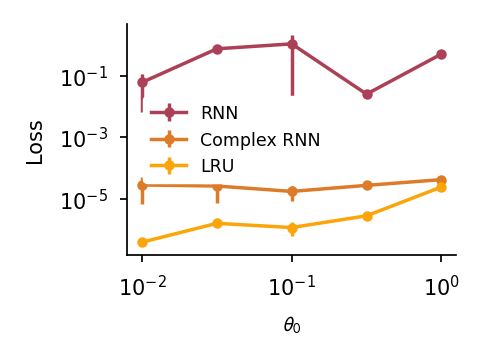

In [26]:
COLORS_RED = [
    "#AC4056",
    "#bc5447",
    "#cc6837",
    "#dc7c28",
    "#ec9019",
    "#FCA50A",
]

colors = [
    COLORS_RED[0],  # RNN
    COLORS_RED[3],  # Complex RNN
    COLORS_RED[-1],  # LRU
]

labels = [
    "RNN",
    "Complex RNN",
    "LRU"
]

fig, ax = plt.subplots(figsize=(1.7, 1.2))

for i, data in enumerate(data_ablation):
    ax.errorbar(data["max_phase"] / jnp.pi, data["Training loss"], yerr=data["Training loss std"], fmt="o", markersize=2, color=colors[i], linestyle="-", linewidth=1, label=labels[i])
# legend on the side


ax.legend( borderaxespad=1, edgecolor="white", fontsize=5, framealpha=1)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\theta_0$")
ax.set_ylabel("Loss")
ax.minorticks_off()